In [ ]:
!pip install torch==1.12.0 torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu116.html
!pip install plotly
!pip install pytorch-metric-learning -q 

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, PointConv, fps, global_max_pool, radius ,DynamicEdgeConv ,EdgeConv 
import plotly.express as px
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_metric_learning.losses import NTXentLoss

from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
gc.collect()

# Utility Functions


In [2]:
def train_model(model,train_loader):
    model.train()

    total_loss = 0
    for data in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_loader)

def evaluate_model(model,val_loader):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in tqdm(val_loader):
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = model(data).max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()
    return (total_loss / len(val_loader), correct / len(val_loader.dataset))


def test_model(model,loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

def train_contrastive(model,data_loader):
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm(data_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        # Get data representations
        h_1, h_2, compact_h_1, compact_h_2 = model(data)
        # Prepare for loss
        embeddings = torch.cat((compact_h_1, compact_h_2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, compact_h_1.size(0), device=compact_h_2.device)
        labels = torch.cat((indices, indices))
        loss = loss_func(embeddings, labels)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(data_loader)

In [3]:
# classes:['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor',
# 'night_stand', 'sofa', 'table', 'toilet']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pre_transform, transform = T.NormalizeScale(), T.SamplePoints(2000)
dataset = ModelNet('modelnet/train/', '10', True, transform, pre_transform)
test_dataset = ModelNet('modelnet/test/', '10', False, transform, pre_transform)
print("Number of train Samples: ", len(dataset))
print("Number of test Samples: ", len(test_dataset))
print("Sample: ", dataset)
print("Sample: ", test_dataset)

Extracting modelnet/train/ModelNet10.zip
Processing...
Done!
Extracting modelnet/test/ModelNet10.zip
Processing...


Number of train Samples:  3991
Number of test Samples:  908
Sample:  ModelNet10(3991)
Sample:  ModelNet10(908)


Done!


# Data preprocessing

In [270]:
percent_data=0.01 #from [0-0.8]--try for 0.01,0.1,0.8
trainData_size=int(len(dataset)*percent_data)
testData_size=int(trainData_size/10)
print("Training Size",trainData_size)
indices = np.arange(len(dataset))

train_indices, test_indices = train_test_split(indices, train_size = trainData_size,test_size=trainData_size, stratify=dataset.data.y)

# Warp into Subsets and DataLoaders
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, shuffle=True, batch_size=32)
val_loader = DataLoader(val_subset, shuffle=False, batch_size=32)

# Validation
train_targets = []
for target in train_loader:
    train_targets.append(target.y)
train_targets = torch.cat(train_targets)

print(train_targets.unique(return_counts=True))

Training Size 39
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([1, 5, 9, 2, 2, 4, 2, 7, 4, 3]))


In [271]:
dataset_loader= DataLoader(dataset, shuffle=True, batch_size=32)#for unsupervised
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

**Plot Some Examples**

In [260]:
def plot_3d_shape(shape):
#     print("Number of data points: ", shape.x.shape[0])
    x = shape.pos[:, 0]
    y = shape.pos[:, 1]
    z = shape.pos[:, 2]
    fig = px.scatter_3d(x=x, y=y, z=z, opacity=0.3)
    fig.show()

# Pick a sample
sample_idx = 55
# plot_3d_shape(train_subset[sample_idx])

# POINTNET 2

Training Pointnet2 uisng all data withoit any pretraining

In [261]:
class SAModule(torch.nn.Module):
    def __init__(self, ratio, r, nn):
        super().__init__()
        self.ratio = ratio
        self.r = r
        self.conv = PointConv(nn, add_self_loops=True)

    def forward(self, x, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=64)
        edge_index = torch.stack([col, row], dim=0)
        x_dst = None if x is None else x[idx]
        x = self.conv((x, x_dst), (pos, pos[idx]), edge_index)
        pos, batch = pos[idx], batch[idx]
        return x, pos, batch


class GlobalSAModule(torch.nn.Module):
    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def forward(self, x, pos, batch):
        x = self.nn(torch.cat([x, pos], dim=1))
        x = global_max_pool(x, batch)
        pos = pos.new_zeros((x.size(0), 3))
        batch = torch.arange(x.size(0), device=batch.device)
        return x, pos, batch


class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([3, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.4, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = GlobalSAModule(MLP([256 + 3, 256, 512, 1024]))

        self.mlp = MLP([1024, 512, 256, 16], dropout=0.5, norm=None)

    def forward(self, data):
        sa0_out = (data.x, data.pos, data.batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        x, pos, batch = sa3_out
        return self.mlp(x).log_softmax(dim=-1)



In [262]:
PointNetwork = PointNet().to(device)
optimizer = torch.optim.Adam(PointNetwork.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
for epoch in range(0, 50):
    loss = train_model(PointNetwork,train_loader)
    test_loss,test_acc = evaluate_model(PointNetwork,val_loader)
    print(f'Epoch {epoch:03d}, Train_Loss: {loss:.4f},Test_Loss: {test_loss:.4f}, Test_acc: {test_acc:.4f}')
#     scheduler.step()


100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


Epoch 000, Train_Loss: 55.0787,Test_Loss: 53.9146, Test_acc: 0.0000


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Epoch 001, Train_Loss: 48.6109,Test_Loss: 53.5828, Test_acc: 0.1795


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Epoch 002, Train_Loss: 50.8629,Test_Loss: 53.2540, Test_acc: 0.1795


100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


Epoch 003, Train_Loss: 47.1114,Test_Loss: 53.0694, Test_acc: 0.1795


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


Epoch 004, Train_Loss: 47.3129,Test_Loss: 52.5938, Test_acc: 0.1026


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Epoch 005, Train_Loss: 44.6864,Test_Loss: 51.4596, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Epoch 006, Train_Loss: 42.5361,Test_Loss: 49.7326, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


Epoch 007, Train_Loss: 42.0899,Test_Loss: 47.7833, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch 008, Train_Loss: 43.6233,Test_Loss: 45.7935, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Epoch 009, Train_Loss: 45.0948,Test_Loss: 43.8961, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 010, Train_Loss: 43.9118,Test_Loss: 42.9786, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch 011, Train_Loss: 44.0714,Test_Loss: 43.4295, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Epoch 012, Train_Loss: 43.8793,Test_Loss: 44.6263, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Epoch 013, Train_Loss: 44.3538,Test_Loss: 46.8866, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 014, Train_Loss: 44.6973,Test_Loss: 50.5614, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


Epoch 015, Train_Loss: 42.0527,Test_Loss: 54.4836, Test_acc: 0.1795


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Epoch 016, Train_Loss: 39.9665,Test_Loss: 56.1400, Test_acc: 0.1795


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 017, Train_Loss: 40.0975,Test_Loss: 56.8232, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


Epoch 018, Train_Loss: 39.9094,Test_Loss: 56.6188, Test_acc: 0.2564


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 019, Train_Loss: 36.6319,Test_Loss: 58.7478, Test_acc: 0.1282


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch 020, Train_Loss: 37.4786,Test_Loss: 61.9620, Test_acc: 0.1282


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Epoch 021, Train_Loss: 33.2173,Test_Loss: 68.4526, Test_acc: 0.1282


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch 022, Train_Loss: 30.3425,Test_Loss: 71.4395, Test_acc: 0.1282


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


Epoch 023, Train_Loss: 28.0420,Test_Loss: 61.1388, Test_acc: 0.1538


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Epoch 024, Train_Loss: 26.8815,Test_Loss: 50.9613, Test_acc: 0.1538


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Epoch 025, Train_Loss: 34.4975,Test_Loss: 47.8330, Test_acc: 0.1795


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


Epoch 026, Train_Loss: 28.0173,Test_Loss: 47.0782, Test_acc: 0.1282


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 027, Train_Loss: 31.4666,Test_Loss: 42.5055, Test_acc: 0.2308


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


Epoch 028, Train_Loss: 30.7462,Test_Loss: 30.7400, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


Epoch 029, Train_Loss: 28.9787,Test_Loss: 28.3441, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


Epoch 030, Train_Loss: 26.7215,Test_Loss: 30.7494, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


Epoch 031, Train_Loss: 24.9527,Test_Loss: 35.4421, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 032, Train_Loss: 21.8558,Test_Loss: 43.9471, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch 033, Train_Loss: 24.3600,Test_Loss: 41.9340, Test_acc: 0.4103


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Epoch 034, Train_Loss: 19.7727,Test_Loss: 32.4751, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


Epoch 035, Train_Loss: 24.3527,Test_Loss: 28.2073, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


Epoch 036, Train_Loss: 21.2610,Test_Loss: 31.0793, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 037, Train_Loss: 19.0748,Test_Loss: 31.3580, Test_acc: 0.4103


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch 038, Train_Loss: 28.6435,Test_Loss: 23.2075, Test_acc: 0.5128


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch 039, Train_Loss: 22.2604,Test_Loss: 24.8210, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 040, Train_Loss: 23.4695,Test_Loss: 27.3347, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


Epoch 041, Train_Loss: 19.9060,Test_Loss: 24.9612, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 042, Train_Loss: 17.5452,Test_Loss: 23.9317, Test_acc: 0.6154


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 043, Train_Loss: 16.0716,Test_Loss: 29.9487, Test_acc: 0.3590


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 044, Train_Loss: 30.8369,Test_Loss: 21.8742, Test_acc: 0.5385


100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


Epoch 045, Train_Loss: 21.0167,Test_Loss: 28.9343, Test_acc: 0.5128


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch 046, Train_Loss: 23.4239,Test_Loss: 35.4975, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


Epoch 047, Train_Loss: 23.0202,Test_Loss: 43.5643, Test_acc: 0.4872


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 048, Train_Loss: 26.9521,Test_Loss: 32.3971, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

Epoch 049, Train_Loss: 16.2708,Test_Loss: 33.7221, Test_acc: 0.4359


In [ ]:
PointNetwork = PointNet().to(device)
PointNetwork.load_state_dict(torch.load('/kaggle/working/PointNet_saved_model_final.pth'))
PointNetwork.eval()

In [264]:
test_model(PointNetwork,test_loader)

0.2907488986784141

In [ ]:
torch.save(PointNetwork.state_dict(), 'PointNet_saved_model_final.pth')

In [249]:
del PointNetwork

# Dynamic Graph CNN
Training EdgeConvNet uisng all data withoit any pretraining

In [272]:
class EdgeConvNet(torch.nn.Module):
    def __init__(self, out_channels, k=20, aggr='max'):
        super().__init__()

        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        self.lin1 = Linear(128 + 64, 1024)

        self.mlp = MLP([1024, 256, out_channels], dropout=0.5, norm=None)

    def forward(self, data):
        pos, batch = data.pos, data.batch
        x1 = self.conv1(pos, batch)
        x2 = self.conv2(x1, batch)
        out = self.lin1(torch.cat([x1, x2], dim=1))
        out = global_max_pool(out, batch)
        out = self.mlp(out)
        return F.log_softmax(out, dim=1)




In [ ]:
EdgeConvNetwork = EdgeConvNet(10, k=20).to(device)
optimizer = torch.optim.Adam(EdgeConvNetwork.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
for epoch in range(0, 50):
    loss = train_model(EdgeConvNetwork,train_loader)
    test_loss,test_acc = evaluate_model(EdgeConvNetwork,val_loader)
    print(f'Epoch {epoch:03d}, Train_Loss: {loss:.4f},Test_Loss: {test_loss:.4f}, Test_acc: {test_acc:.4f}')
#     scheduler.step()

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 000, Train_Loss: 44.8018,Test_Loss: 43.9627, Test_acc: 0.2308


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 001, Train_Loss: 43.0105,Test_Loss: 43.3095, Test_acc: 0.3333


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch 002, Train_Loss: 40.6363,Test_Loss: 42.6750, Test_acc: 0.2308


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 003, Train_Loss: 41.2893,Test_Loss: 42.3210, Test_acc: 0.2308


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 004, Train_Loss: 41.2884,Test_Loss: 42.1525, Test_acc: 0.2308


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 005, Train_Loss: 39.8061,Test_Loss: 42.1579, Test_acc: 0.2308


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 006, Train_Loss: 39.7119,Test_Loss: 41.9612, Test_acc: 0.3590


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 007, Train_Loss: 39.2997,Test_Loss: 41.4982, Test_acc: 0.4103


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 008, Train_Loss: 35.7657,Test_Loss: 40.8445, Test_acc: 0.4615


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 009, Train_Loss: 36.9501,Test_Loss: 39.7889, Test_acc: 0.4872


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch 010, Train_Loss: 35.0781,Test_Loss: 38.3388, Test_acc: 0.5385


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch 011, Train_Loss: 34.5369,Test_Loss: 36.9386, Test_acc: 0.5385


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 012, Train_Loss: 35.9485,Test_Loss: 35.5127, Test_acc: 0.5641


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 013, Train_Loss: 33.4952,Test_Loss: 34.4675, Test_acc: 0.5385


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch 014, Train_Loss: 32.0416,Test_Loss: 33.7081, Test_acc: 0.5128


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 015, Train_Loss: 32.1242,Test_Loss: 32.1422, Test_acc: 0.5128


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 016, Train_Loss: 27.8150,Test_Loss: 30.8442, Test_acc: 0.5128


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch 017, Train_Loss: 26.0206,Test_Loss: 29.7446, Test_acc: 0.5128


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 018, Train_Loss: 27.2635,Test_Loss: 28.6199, Test_acc: 0.5128


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch 019, Train_Loss: 25.7270,Test_Loss: 28.0375, Test_acc: 0.5641


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 020, Train_Loss: 24.1766,Test_Loss: 26.8877, Test_acc: 0.5641


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 021, Train_Loss: 26.1093,Test_Loss: 25.1430, Test_acc: 0.5897


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 022, Train_Loss: 26.4422,Test_Loss: 24.3270, Test_acc: 0.6410


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 023, Train_Loss: 19.8665,Test_Loss: 23.9712, Test_acc: 0.6154


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch 024, Train_Loss: 19.9371,Test_Loss: 23.8712, Test_acc: 0.6154


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch 025, Train_Loss: 22.0079,Test_Loss: 23.0097, Test_acc: 0.6154


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 026, Train_Loss: 21.1416,Test_Loss: 22.0831, Test_acc: 0.6667


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 027, Train_Loss: 21.3500,Test_Loss: 21.5660, Test_acc: 0.6667


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 028, Train_Loss: 20.4533,Test_Loss: 21.2488, Test_acc: 0.6154


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch 029, Train_Loss: 19.1269,Test_Loss: 21.5500, Test_acc: 0.5897


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 030, Train_Loss: 17.5194,Test_Loss: 22.3630, Test_acc: 0.5641


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 031, Train_Loss: 19.4252,Test_Loss: 21.8478, Test_acc: 0.6154


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 032, Train_Loss: 15.4319,Test_Loss: 20.4711, Test_acc: 0.6667


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 033, Train_Loss: 11.5073,Test_Loss: 18.7811, Test_acc: 0.6923


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch 034, Train_Loss: 12.6448,Test_Loss: 17.9777, Test_acc: 0.6923


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 035, Train_Loss: 13.1019,Test_Loss: 18.9983, Test_acc: 0.7179


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 036, Train_Loss: 14.7964,Test_Loss: 18.2856, Test_acc: 0.6923


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch 037, Train_Loss: 13.7128,Test_Loss: 19.8737, Test_acc: 0.6410


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch 038, Train_Loss: 17.0446,Test_Loss: 20.7587, Test_acc: 0.6410


100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Epoch 039, Train_Loss: 14.3778,Test_Loss: 19.5123, Test_acc: 0.6923


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 040, Train_Loss: 14.2480,Test_Loss: 19.2227, Test_acc: 0.7179


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 041, Train_Loss: 9.5842,Test_Loss: 19.9879, Test_acc: 0.6410


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 042, Train_Loss: 12.2358,Test_Loss: 20.4509, Test_acc: 0.6410


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch 043, Train_Loss: 16.4403,Test_Loss: 20.6370, Test_acc: 0.6154


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch 044, Train_Loss: 13.2537,Test_Loss: 22.3607, Test_acc: 0.5897


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch 045, Train_Loss: 14.0326,Test_Loss: 19.8997, Test_acc: 0.6154


  0%|          | 0/2 [00:00<?, ?it/s]

In [274]:
test_model(EdgeConvNetwork,test_loader)

0.6189427312775331

In [ ]:
torch.save(EdgeConvNetwork.state_dict(), 'EdgeConvNet_saved_model_final.pth')

In [31]:
del EdgeConvNet

NameError: name 'EdgeConvNet' is not defined

# Pre-training using Contrastive approach

In this section we apply **Augmentations** to the graph data and train in unsupervised manner using NT-Xent Loss

In [ ]:
# augmentation = T.Compose(
#     [
#       T.RandomJitter(0.05), 
#       T.RandomShear(0.1),
#       T.RandomRotate(degrees=180),
#       T.RandomScale((0.1,0.9))
#     ]
# )

In [8]:
augmentation = T.Compose([T.RandomJitter(0.03),
                          T.RandomFlip(1),
                          T.RandomShear(0.2)])

In [ ]:
sample = next(iter(dataset_loader))
# plot_3d_shape(sample[0])


In [ ]:
transformered = augmentation(sample)
# plot_3d_shape(transformered[0])

# Pre-train Dynamic Graph CNN model

In [192]:
class EdgeConvNet_ContrasriveNet(torch.nn.Module):
    def __init__(self, k=20, aggr='max'):
        super().__init__()
        # Feature extraction
        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64,128 , 128]), k, aggr)
        self.conv3 = DynamicEdgeConv(MLP([2 * 128, 256]), k, aggr)
        # Encoder head 
        self.lin1 = Linear(128 + 64 + 256  , 1024)
        # Projection head (See explanation in SimCLRv2)
        self.ph1 = Linear(1024, 1024)
        self.ph2 = Linear(1024, 512)
        self.ph3 = Linear(512 , 64)
        

    def forward(self, data, train=True):
        if train:
            # Get 2 augmentations of the batch
            augm_1 = augmentation(data)
            augm_2 = augmentation(data)

            # Extract properties
            pos_1, batch_1 = augm_1.pos, augm_1.batch
            pos_2, batch_2 = augm_2.pos, augm_2.batch

            # Get representations for first augmented view
            x1 = self.conv1(pos_1, batch_1)
            x2 = self.conv2(x1, batch_1)
            x3 = self.conv3(x2, batch_1)
            h_points_1 = self.lin1(torch.cat([x1, x2, x3], dim=1))

            # Get representations for second augmented view
            x1 = self.conv1(pos_2, batch_2)
            x2 = self.conv2(x1, batch_2)
            x3 = self.conv3(x2, batch_2)
            h_points_2 = self.lin1(torch.cat([x1, x2, x3], dim=1))
            
            # Global representation
            h_1 = global_max_pool(h_points_1, batch_1)
            h_2 = global_max_pool(h_points_2, batch_2)
        else:
            x1 = self.conv1(data.pos, data.batch)
            x2 = self.conv2(x1, data.batch)
            x3 = self.conv3(x2, data.batch)
            h_points = self.lin1(torch.cat([x1, x2, x3], dim=1))
            return global_max_pool(h_points, data.batch)

        # Transformation for loss function
        c1_h1= self.ph1(h_1)
        c2_h1= F.relu(self.ph2(c1_h1))
        compact_h_1= self.ph3(c2_h1)
        
        c1_h2= self.ph1(h_2)
        c2_h2= F.relu(self.ph2(c1_h2))
        compact_h_2 = self.ph3(c2_h2)
        
        return h_1, h_2, compact_h_1, compact_h_2

In [10]:
EdgeConvNet_Contrasrive = EdgeConvNet_ContrasriveNet().to(device)
optimizer = torch.optim.Adam(EdgeConvNet_Contrasrive.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_func = NTXentLoss(temperature=0.10)

In [11]:
for epoch in range(0, 15):
    loss = train_contrastive(EdgeConvNet_Contrasrive,dataset_loader)
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|██████████| 125/125 [07:09<00:00,  3.43s/it]


Epoch 000, Loss: 35.9220


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 001, Loss: 16.4689


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 002, Loss: 12.9663


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 003, Loss: 9.8972


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 004, Loss: 8.1038


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 005, Loss: 6.3085


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 006, Loss: 5.9432


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 007, Loss: 5.1582


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 008, Loss: 5.2868


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 009, Loss: 5.0011


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 010, Loss: 3.9540


100%|██████████| 125/125 [07:07<00:00,  3.42s/it]


Epoch 011, Loss: 3.4026


100%|██████████| 125/125 [07:06<00:00,  3.42s/it]


Epoch 012, Loss: 3.4249


100%|██████████| 125/125 [07:06<00:00,  3.42s/it]


Epoch 013, Loss: 3.2752


100%|██████████| 125/125 [07:06<00:00,  3.41s/it]

Epoch 014, Loss: 2.4788


In [12]:
torch.save(EdgeConvNet_Contrasrive.state_dict( ), 'EdgeConvNet_Contrasrive_saved_model_final_aug2.pth')

In [30]:
del EdgeConvNet_Contrasrive

# Pre-train PointNet2 model

In [193]:
class PointNetContrasriveNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([3, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.3, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = SAModule(0.25, 0.4, MLP([256 + 3, 256, 256, 512]))
        self.sa4_module = GlobalSAModule(MLP([512 + 3, 512, 512, 1024]))
        # Projection head (See explanation in SimCLRv2)
        self.ph1 = Linear(1024, 1024)
        self.ph2 = Linear(1024, 512)
        self.ph3 = Linear(512 , 64)
        

    def forward(self, data, train=True):
        if train:
            # Get 2 augmentations of the batch
            augm_1 = augmentation(data)
            augm_2 = augmentation(data)
            
            #extraxt features from aug1
            sa0_out = (augm_1.x, augm_1.pos, augm_1.batch)
            sa1_out = self.sa1_module(*sa0_out)
            sa2_out = self.sa2_module(*sa1_out)
            sa3_out = self.sa3_module(*sa2_out)
            sa4_out = self.sa4_module(*sa3_out)
            h_1, _ , _ = sa4_out
            
            #extraxt features from aug1
            sa0_out = (augm_2.x, augm_2.pos, augm_2.batch)
            sa1_out = self.sa1_module(*sa0_out)
            sa2_out = self.sa2_module(*sa1_out)
            sa3_out = self.sa3_module(*sa2_out)
            sa4_out = self.sa4_module(*sa3_out)
            h_2, _, _ = sa4_out
            
        else:
            sa0_out = (data.x, data.pos, data.batch)
            sa1_out = self.sa1_module(*sa0_out)
            sa2_out = self.sa2_module(*sa1_out)
            sa3_out = self.sa3_module(*sa2_out)
            sa4_out = self.sa4_module(*sa3_out)
            h_points, _ , _ = sa4_out
            return h_points

        # Transformation for loss function
        c1_h1= self.ph1(h_1)
        c2_h1= F.relu(self.ph2(c1_h1))
        compact_h_1= self.ph3(c2_h1)
        
        c1_h2= self.ph1(h_2)
        c2_h2= F.relu(self.ph2(c1_h2))
        compact_h_2 = self.ph3(c2_h2)
        
        return h_1, h_2, compact_h_1, compact_h_2

In [14]:
PointNetContrasrive = PointNetContrasriveNet().to(device)
optimizer = torch.optim.Adam(PointNetContrasrive.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_func = NTXentLoss(temperature=0.10)

In [19]:
for epoch in range(0, 10):
    loss = train_contrastive(PointNetContrasrive,dataset_loader)
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


Epoch 000, Loss: 1.8817


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


Epoch 001, Loss: 1.5870


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


Epoch 002, Loss: 1.6274


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


Epoch 003, Loss: 1.4055


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


Epoch 004, Loss: 1.3402


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


Epoch 005, Loss: 1.3674


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


Epoch 006, Loss: 1.5711


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


Epoch 007, Loss: 1.4040


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]


Epoch 008, Loss: 1.3915


100%|██████████| 125/125 [01:15<00:00,  1.65it/s]

Epoch 009, Loss: 1.3724


In [20]:
torch.save(PointNetContrasrive.state_dict(),'PointNetContrasrive_test_final30_aug2.pth')

In [32]:
del PointNetContrasrive

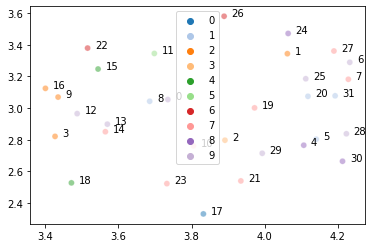

In [23]:
# Get sample batch
sample = next(iter(dataset_loader))

# Get representations
h = PointNetContrasrive(sample.to(device), train=False)
h = h.cpu().detach()
labels = sample.y.cpu().detach().numpy()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

# Plot
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], hue=labels, 
                    alpha=0.5, palette="tab20")

# Add labels to be able to identify the data points
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]), 
            pd.Series(h_embedded[:,1]), 
            pd.Series(annotations), 
            plt.gca()) 

In [27]:
import numpy as np

def sim_matrix(a, b, eps=1e-8):
    """
    Eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

similarity = sim_matrix(h, h)
max_indices = torch.topk(similarity, k=2)[1][:, 1]
max_vals  = torch.topk(similarity, k=2)[0][:, 1]

# Select index
idx = 3
similar_idx = max_indices[idx]
print(f"Most similar data point in the embedding space for {idx} is {similar_idx}")

Most similar data point in the embedding space for 3 is 16


In [28]:
plot_3d_shape(sample[idx].cpu())

In [29]:
plot_3d_shape(sample[similar_idx].cpu())

# Fine_tune on Classification task


**1.Fine tuning Pointnet Network**

In [218]:
pointnet_path='/kaggle/input/trained-models/PointNetContrasrive_test_final30.pth'
pointnet2_saved=PointNetContrasriveNet().to(device)
pointnet2_saved.load_state_dict(torch.load(pointnet_path))
pointnet2_saved.ph3 = torch.nn.Linear(512, 10)

In [219]:
class PointNetFineTuned(torch.nn.Module):
    def __init__(self,trained_model, ):
        super().__init__()
        # Feature extraction
        self.pre_trained_model = trained_model

    def forward(self, data):
            out = self.pre_trained_model(data, train=False)
            return F.log_softmax(out, dim=1)

In [220]:
pointnet_finetuned= PointNetFineTuned(pointnet2_saved).to(device)
optimizer = torch.optim.Adam(pointnet_finetuned.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
for epoch in range(0, 100):
    loss = train_model(pointnet_finetuned,train_loader)
    test_loss,test_acc = evaluate_model(pointnet_finetuned,val_loader)
    print(f'Epoch {epoch:03d}, Train_Loss: {loss:.4f},Test_Loss: {test_loss:.4f}, Test_acc: {test_acc:.4f}')
#     scheduler.step()


100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


Epoch 000, Train_Loss: 166.4540,Test_Loss: 517.3996, Test_acc: 0.0000


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Epoch 001, Train_Loss: 139.0410,Test_Loss: 325.0129, Test_acc: 0.0256


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 002, Train_Loss: 116.4869,Test_Loss: 232.7490, Test_acc: 0.0256


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 003, Train_Loss: 86.5799,Test_Loss: 160.2549, Test_acc: 0.0256


100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


Epoch 004, Train_Loss: 65.4280,Test_Loss: 112.2849, Test_acc: 0.1282


100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


Epoch 005, Train_Loss: 54.6087,Test_Loss: 92.3832, Test_acc: 0.2821


100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


Epoch 006, Train_Loss: 48.8196,Test_Loss: 83.0932, Test_acc: 0.2564


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 007, Train_Loss: 38.9345,Test_Loss: 69.5054, Test_acc: 0.3333


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 008, Train_Loss: 36.7157,Test_Loss: 55.3462, Test_acc: 0.3590


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 009, Train_Loss: 35.2400,Test_Loss: 48.6118, Test_acc: 0.3333


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


Epoch 010, Train_Loss: 28.5371,Test_Loss: 45.1378, Test_acc: 0.3846


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 011, Train_Loss: 30.1154,Test_Loss: 43.7091, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 012, Train_Loss: 35.2151,Test_Loss: 38.0929, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 013, Train_Loss: 33.5177,Test_Loss: 36.8238, Test_acc: 0.5385


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 014, Train_Loss: 22.5752,Test_Loss: 40.3418, Test_acc: 0.3846


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 015, Train_Loss: 24.5431,Test_Loss: 42.7152, Test_acc: 0.4872


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 016, Train_Loss: 26.5647,Test_Loss: 44.5230, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 017, Train_Loss: 21.8695,Test_Loss: 42.6932, Test_acc: 0.4103


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 018, Train_Loss: 27.3305,Test_Loss: 41.2741, Test_acc: 0.3846


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Epoch 019, Train_Loss: 18.3234,Test_Loss: 38.2595, Test_acc: 0.5128


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


Epoch 020, Train_Loss: 23.2606,Test_Loss: 34.3178, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 021, Train_Loss: 21.4897,Test_Loss: 37.3484, Test_acc: 0.5385


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 022, Train_Loss: 21.0300,Test_Loss: 32.3055, Test_acc: 0.5128


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 023, Train_Loss: 30.2326,Test_Loss: 31.2241, Test_acc: 0.5641


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


Epoch 024, Train_Loss: 20.4536,Test_Loss: 31.4709, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 025, Train_Loss: 17.8232,Test_Loss: 34.0597, Test_acc: 0.4872


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch 026, Train_Loss: 19.5025,Test_Loss: 30.2708, Test_acc: 0.5641


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


Epoch 027, Train_Loss: 16.8557,Test_Loss: 33.3367, Test_acc: 0.5385


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 028, Train_Loss: 20.5160,Test_Loss: 28.9603, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


Epoch 029, Train_Loss: 19.2596,Test_Loss: 30.0655, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Epoch 030, Train_Loss: 22.3121,Test_Loss: 31.1213, Test_acc: 0.4872


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 031, Train_Loss: 20.9887,Test_Loss: 31.3591, Test_acc: 0.4872


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


Epoch 032, Train_Loss: 20.7702,Test_Loss: 29.8895, Test_acc: 0.5641


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 033, Train_Loss: 19.0276,Test_Loss: 25.4189, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


Epoch 034, Train_Loss: 16.0101,Test_Loss: 29.6326, Test_acc: 0.5128


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 035, Train_Loss: 18.2397,Test_Loss: 29.5737, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 036, Train_Loss: 19.1692,Test_Loss: 29.2790, Test_acc: 0.5128


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 037, Train_Loss: 13.2952,Test_Loss: 34.6907, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Epoch 038, Train_Loss: 17.8302,Test_Loss: 36.1264, Test_acc: 0.3846


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 039, Train_Loss: 18.2364,Test_Loss: 36.8104, Test_acc: 0.3846


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 040, Train_Loss: 15.4628,Test_Loss: 32.2632, Test_acc: 0.4103


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 041, Train_Loss: 12.8887,Test_Loss: 30.5965, Test_acc: 0.4359


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Epoch 042, Train_Loss: 13.7204,Test_Loss: 28.4298, Test_acc: 0.5385


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Epoch 043, Train_Loss: 12.9866,Test_Loss: 32.9706, Test_acc: 0.4872


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


Epoch 044, Train_Loss: 17.0369,Test_Loss: 25.3787, Test_acc: 0.6154


100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


Epoch 045, Train_Loss: 12.9489,Test_Loss: 28.8869, Test_acc: 0.6154


100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


Epoch 046, Train_Loss: 16.0409,Test_Loss: 23.9720, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch 047, Train_Loss: 17.8698,Test_Loss: 26.8623, Test_acc: 0.6667


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch 048, Train_Loss: 13.4149,Test_Loss: 20.0005, Test_acc: 0.6667


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch 049, Train_Loss: 13.8617,Test_Loss: 19.8586, Test_acc: 0.6923


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 050, Train_Loss: 15.0462,Test_Loss: 25.0107, Test_acc: 0.6667


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


Epoch 051, Train_Loss: 9.0246,Test_Loss: 20.5029, Test_acc: 0.7692


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


Epoch 052, Train_Loss: 12.8958,Test_Loss: 17.8167, Test_acc: 0.7436


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Epoch 053, Train_Loss: 12.9163,Test_Loss: 20.6586, Test_acc: 0.6923


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 054, Train_Loss: 9.5987,Test_Loss: 21.4658, Test_acc: 0.6410


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Epoch 055, Train_Loss: 11.2531,Test_Loss: 18.9141, Test_acc: 0.7692


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Epoch 056, Train_Loss: 8.1196,Test_Loss: 26.5675, Test_acc: 0.6667


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 057, Train_Loss: 13.2555,Test_Loss: 20.6116, Test_acc: 0.7179


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Epoch 058, Train_Loss: 9.9393,Test_Loss: 21.0781, Test_acc: 0.6667


100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


Epoch 059, Train_Loss: 9.9127,Test_Loss: 18.8695, Test_acc: 0.7436


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 060, Train_Loss: 9.6442,Test_Loss: 18.4665, Test_acc: 0.8718


100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


Epoch 061, Train_Loss: 13.7284,Test_Loss: 20.0193, Test_acc: 0.7692


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 062, Train_Loss: 8.2769,Test_Loss: 26.1061, Test_acc: 0.7179


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 063, Train_Loss: 7.9499,Test_Loss: 25.1611, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Epoch 064, Train_Loss: 10.5514,Test_Loss: 25.1792, Test_acc: 0.6923


100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


Epoch 065, Train_Loss: 13.9090,Test_Loss: 25.7112, Test_acc: 0.6923


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 066, Train_Loss: 7.0288,Test_Loss: 23.0874, Test_acc: 0.6923


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 067, Train_Loss: 11.5216,Test_Loss: 23.9826, Test_acc: 0.6667


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 068, Train_Loss: 8.5751,Test_Loss: 26.2354, Test_acc: 0.6410


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 069, Train_Loss: 7.6931,Test_Loss: 25.9285, Test_acc: 0.6154


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 070, Train_Loss: 10.1943,Test_Loss: 21.6810, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch 071, Train_Loss: 11.9788,Test_Loss: 24.4984, Test_acc: 0.6667


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


Epoch 072, Train_Loss: 11.0107,Test_Loss: 28.9625, Test_acc: 0.5385


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 073, Train_Loss: 11.7459,Test_Loss: 30.2659, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 074, Train_Loss: 7.3168,Test_Loss: 31.8345, Test_acc: 0.6154


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


Epoch 075, Train_Loss: 7.1179,Test_Loss: 29.0888, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


Epoch 076, Train_Loss: 4.8611,Test_Loss: 31.4376, Test_acc: 0.6923


100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch 077, Train_Loss: 4.7625,Test_Loss: 26.7097, Test_acc: 0.7436


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch 078, Train_Loss: 8.2329,Test_Loss: 25.2307, Test_acc: 0.6923


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


Epoch 079, Train_Loss: 4.3994,Test_Loss: 31.6946, Test_acc: 0.5385


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 080, Train_Loss: 9.6510,Test_Loss: 28.3094, Test_acc: 0.6410


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch 081, Train_Loss: 7.6062,Test_Loss: 27.0993, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Epoch 082, Train_Loss: 5.0877,Test_Loss: 20.1526, Test_acc: 0.7179


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch 083, Train_Loss: 7.7007,Test_Loss: 19.8028, Test_acc: 0.6923


100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


Epoch 084, Train_Loss: 10.4800,Test_Loss: 20.7890, Test_acc: 0.6667


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


Epoch 085, Train_Loss: 7.0167,Test_Loss: 25.3273, Test_acc: 0.6410


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch 086, Train_Loss: 6.3670,Test_Loss: 26.5934, Test_acc: 0.5385


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


Epoch 087, Train_Loss: 12.7501,Test_Loss: 31.4497, Test_acc: 0.5897


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 088, Train_Loss: 6.8909,Test_Loss: 33.2248, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 089, Train_Loss: 10.6058,Test_Loss: 34.1338, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch 090, Train_Loss: 10.8689,Test_Loss: 41.2058, Test_acc: 0.4615


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Epoch 091, Train_Loss: 8.7944,Test_Loss: 35.7635, Test_acc: 0.5641


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch 092, Train_Loss: 5.4519,Test_Loss: 27.9532, Test_acc: 0.6154


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch 093, Train_Loss: 6.9855,Test_Loss: 24.4372, Test_acc: 0.7692


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 094, Train_Loss: 4.3341,Test_Loss: 23.4748, Test_acc: 0.7436


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 095, Train_Loss: 5.6825,Test_Loss: 20.7377, Test_acc: 0.7436


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


Epoch 096, Train_Loss: 7.3078,Test_Loss: 22.6382, Test_acc: 0.7436


100%|██████████| 2/2 [00:00<00:00,  5.26it/s]


Epoch 097, Train_Loss: 3.3229,Test_Loss: 25.9133, Test_acc: 0.7179


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


Epoch 098, Train_Loss: 2.5729,Test_Loss: 27.2174, Test_acc: 0.7179


100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

Epoch 099, Train_Loss: 7.4465,Test_Loss: 22.1017, Test_acc: 0.6923


In [225]:
test_model(pointnet_finetuned,test_loader)

0.5363436123348018

In [226]:
del pointnet_finetuned

**2. Finetune Dynamic graph CNN model**

In [227]:
edgeconv_path='/kaggle/input/trained-models/EdgeConvNet_Contrasrive_saved_model_final.pth'
EdgeConvNet_saved=EdgeConvNet_ContrasriveNet().to(device)
EdgeConvNet_saved.load_state_dict(torch.load(edgeconv_path))
EdgeConvNet_saved.ph3 = torch.nn.Linear(512, 10)

In [228]:
class EdgeConvFineTuned(torch.nn.Module):
    def __init__(self,trained_model, ):
        super().__init__()
        # Feature extraction
        self.pre_trained_model = trained_model

    def forward(self, data):
            out = self.pre_trained_model(data, train=False)
            return F.log_softmax(out, dim=1)

In [232]:
# EdgeConvNet_finetuned=EdgeConvFineTuned(EdgeConvNet_saved).to(device)
# optimizer = torch.optim.Adam(EdgeConvNet_finetuned.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
for epoch in range(0, 10):
    loss = train_model(EdgeConvNet_finetuned,train_loader)
    test_loss,test_acc = evaluate_model(EdgeConvNet_finetuned,val_loader)
    print(f'Epoch {epoch:03d}, Train_Loss: {loss:.4f},Test_Loss: {test_loss:.4f}, Test_acc: {test_acc:.4f}')

100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Epoch 000, Train_Loss: 13.2681,Test_Loss: 26.2889, Test_acc: 0.5897


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Epoch 001, Train_Loss: 12.9395,Test_Loss: 34.3519, Test_acc: 0.4359


100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


Epoch 002, Train_Loss: 10.8498,Test_Loss: 28.9836, Test_acc: 0.4872


100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


Epoch 003, Train_Loss: 10.7012,Test_Loss: 30.6925, Test_acc: 0.4872


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Epoch 004, Train_Loss: 14.8279,Test_Loss: 34.6839, Test_acc: 0.4359


100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


Epoch 005, Train_Loss: 13.4811,Test_Loss: 35.4015, Test_acc: 0.4615


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Epoch 006, Train_Loss: 12.4466,Test_Loss: 36.7027, Test_acc: 0.4359


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Epoch 007, Train_Loss: 14.8343,Test_Loss: 35.7192, Test_acc: 0.4872


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Epoch 008, Train_Loss: 11.9657,Test_Loss: 29.6435, Test_acc: 0.5385


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]

Epoch 009, Train_Loss: 8.1320,Test_Loss: 33.8730, Test_acc: 0.5385


In [234]:
test_model(EdgeConvNet_finetuned,test_loader)

0.3766519823788546